In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons

import scipy

import torch
import torch.nn as nn
import math

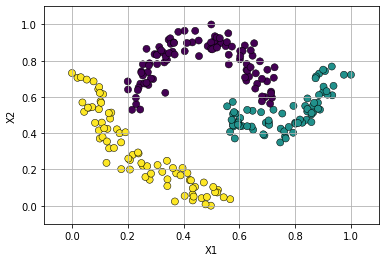

In [2]:
np.random.seed(249) ## 148, 249

xxc, yc = make_circles(n_samples=600, factor=.5,
                                      noise=.09)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<-1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

msk0 = np.bitwise_and(ym==1 ,xxm[:, 0] > 0)
msk1 = ym==0
msk = msk0 | msk1
xxm = xxm[msk]
ym = ym[msk]

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

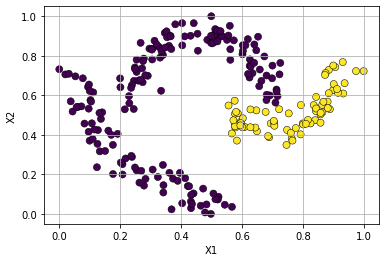

In [25]:
inp = torch.tensor(xx, dtype=torch.float32)
yy = torch.tensor((y==1).astype(np.int64), dtype=torch.float32).reshape(-1,1)

%matplotlib inline
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=50, edgecolors='k', lw=0.5)

plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [26]:
# # https://github.com/pytorch/pytorch/blob/master/torch/distributions/multivariate_normal.py
# def _batch_mv(bmat, bvec):
#     r"""
#     Performs a batched matrix-vector product, with compatible but different batch shapes.
#     This function takes as input `bmat`, containing :math:`n \times n` matrices, and
#     `bvec`, containing length :math:`n` vectors.
#     Both `bmat` and `bvec` may have any number of leading dimensions, which correspond
#     to a batch shape. They are not necessarily assumed to have the same batch shape,
#     just ones which can be broadcasted.
#     """
#     return torch.matmul(bmat, bvec.unsqueeze(-1)).squeeze(-1)

In [42]:
class Bandpass(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        ##mean, var, a
        self.mean = nn.Parameter(torch.zeros(1,input_dim, dtype=torch.float32))
        self.icov = nn.Parameter(torch.eye(input_dim, input_dim, dtype=torch.float32)*2)
        self.a = nn.Parameter(torch.tensor([1], dtype=torch.float32))
#         self.a = torch.tensor([1], dtype=torch.float32)

        
    def forward(self, x):
        self.a.data = torch.clamp(self.a.data, 0.01, 100)
        x = x-self.mean
#         print(x.unsqueeze(1).shape)
        xm = torch.matmul(x.unsqueeze(1), self.icov)#.squeeze(1)
#         print(xm.shape)
        xm = torch.matmul(xm, x.unsqueeze(2)).squeeze(1)
#         print(xm.shape)
        xm = torch.abs(xm)
#         xm = torch.exp(-(xm**torch.exp(self.a)))
        xm = torch.exp(-(xm**self.a))

        return xm

In [43]:
bp = Bandpass(2)

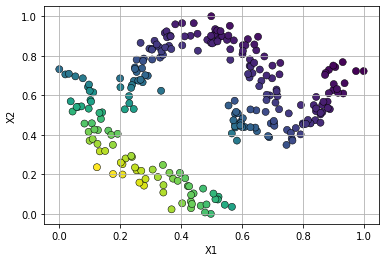

In [44]:
with torch.no_grad():
    yout = bp(inp)
%matplotlib inline
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [45]:
bpNet = Bandpass(2)

optimizer = torch.optim.Adam(bpNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [46]:
%matplotlib tk

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

for epoch in range(10000):
    yout = bpNet(inp)    
#     if torch.any(yout>1) or torch.any(yout<0):
#         print("values not in range 0,1")
    loss = criterion(torch.clamp(yout, 0, 1), yy)

    optimizer.zero_grad()
    loss.backward()
    
#     if epoch<3000:
#         bpNet.a.grad *= 0.
    
    optimizer.step()
   
    if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}, A: {np.exp(float(bpNet.a.data[0]))}')
#         print(bpNet.icov)
        ax.clear()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1)>0.5, marker='.')
        
#         ax.xlabel("X1")
#         ax.ylabel('X2')
        ax.grid()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.9476858973503113, A: 2.6912344980148744


Epoch: 100, Loss:0.45375025272369385, A: 2.047400568957732


Epoch: 200, Loss:0.2505217492580414, A: 4.31544840851


Epoch: 300, Loss:0.1965879499912262, A: 6.731825830246319


Epoch: 400, Loss:0.16960886120796204, A: 9.19925853382555


Epoch: 500, Loss:0.15061411261558533, A: 11.95575906968592


Epoch: 600, Loss:0.13643677532672882, A: 15.120595840339341


Epoch: 700, Loss:0.1257505714893341, A: 18.76258073682846


Epoch: 800, Loss:0.11767269670963287, A: 22.90413851724243


Epoch: 900, Loss:0.11146315187215805, A: 27.539606110158946


Epoch: 1000, Loss:0.10653235763311386, A: 32.65516127376054


Epoch: 1100, Loss:0.10246700793504715, A: 38.24714650736574


Epoch: 1200, Loss:0.09900925308465958, A: 44.33484492648856


Epoch: 1300, Loss:0.0960107296705246, A: 50.96552800557177


Epoch: 1400, Loss:0.0933900699019432, A: 58.21361947676799


Epoch: 1500, Loss:0.09110363572835922, A: 66.17780549905032


Epoch: 1600, Loss:0.08912640

TclError: invalid command name "pyimage60"

In [32]:
# yout

In [33]:
# def forward(self, x):
#     self.a.data = torch.clamp(self.a.data, 0.1, 50)
#     x = x-self.mean
#     print(x)
# #         print(x.unsqueeze(1).shape)
#     xm = torch.matmul(x.unsqueeze(1), self.icov)#.squeeze(1)
#     print(xm)
# #         print(xm.shape)
#     xm = torch.matmul(xm, x.unsqueeze(2)).squeeze(1)
# #         print(xm.shape)
#     print(xm)

#     xm = torch.exp(-(xm**self.a))
#     return xm

In [47]:
bpNet.a

Parameter containing:
tensor([5.4255], requires_grad=True)

In [35]:
# forward(bpNet, inp)

## Plot the classifier surface

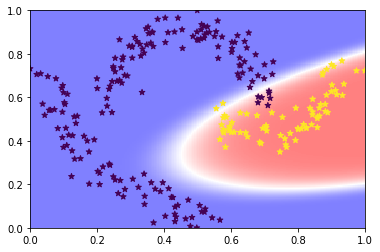

In [52]:
n = 200
x_, y_ = np.meshgrid(np.linspace(xx[:,0].min(), xx[:,0].max(), n), np.linspace(xx[:,1].min(), xx[:,1].max(), n))
xx_img = np.c_[x_.ravel(), y_.ravel()]
xx_img = torch.FloatTensor(xx_img)

yout_img = bpNet(xx_img)
# out = (yout_img.data.numpy()>0.5).astype(int)
out = yout_img.data.numpy().astype(float)

colors = ['r', 'y', 'g', 'b']
%matplotlib inline
plt.imshow(out.reshape(x_.shape), interpolation='nearest',
           extent=(x_.min(), x_.max(), y_.min(), y_.max()),
#            cmap=matplotlib.colors.ListedColormap(colors[1:-1]),
           cmap = matplotlib.cm.bwr,
           alpha=0.5,
           aspect='auto', origin='lower')

plt.scatter(xx[:,0], xx[:, 1], c=yy.data.numpy().reshape(-1), marker='*')

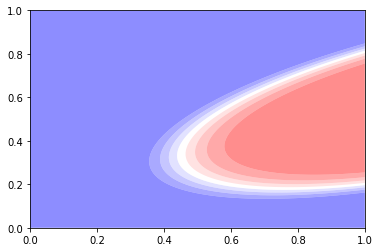

In [80]:
v = np.linspace(0.0, 1.0, 10, endpoint=True)
cf = plt.contourf(x_, y_, out.reshape(x_.shape), v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
# co = plt.contour(x_, y_, out.reshape(x_.shape), v, alpha=0.5, cmap=matplotlib.cm.bwr)
# cbar = fig.colorbar(cf)
plt.show()

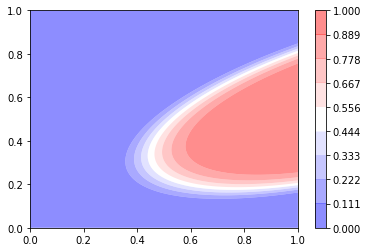

In [81]:
fig, ax = plt.subplots()
cs = plt.contourf(x_, y_, out.reshape(x_.shape),
                  v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)

cbar = fig.colorbar(cs)
plt.show()

In [49]:
# xx[0], yy[0]

In [50]:
np.linalg.inv(bpNet.icov.data.numpy())

array([[0.7808253 , 0.24196923],
       [0.24196923, 0.18828796]], dtype=float32)